<a href="https://colab.research.google.com/github/alexandreib/QuantDesign/blob/main/QD%20%7C%20SP500%20Portfolio%20Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sharpe Ratio Optimization on returns, on S&P 500 Past Returns**



In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

# Creating the DataFrame

## Scraping SP500 Constituents from Wikipedia

In [2]:
# Download the S&P 500 constituents from Wikipedia
try:
    table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = table[0]
    tickers = df['Symbol'].tolist()
except Exception as e:
    print(f"Error downloading S&P 500 tickers: {e}")
    tickers = [] # Handle the error gracefully, e.g., provide a default list

# Print or use the tickers list
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMTM', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', '

## Download the last 10 years of price using Yahoo Finance

In [3]:
# Define the start and end dates for the data
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=365 * 10)

# Download the data
df = yf.download(tickers, start=start_date, end=end_date)

# Print the data (optional)
df.head()

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-10-31 12:23:39.731067 -> 2024-10-28 12:23:39.731067)')
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Price                      Adj Close                                        \
Ticker                             A       AAPL       ABBV ABNB        ABT   
Date                                                                         
2014-10-31 00:00:00+00:00  36.393883  23.973497  41.956585  NaN  36.026073   
2014-11-03 00:00:00+00:00  37.588356  24.284264  41.817745  NaN  35.778118   
2014-11-04 00:00:00+00:00  36.980888  24.106680  41.427666  NaN  36.042599   
2014-11-05 00:00:00+00:00  36.934883  24.164400  41.348328  NaN  36.083912   
2014-11-06 00:00:00+00:00  38.076145  24.233511  41.460712  NaN  36.108715   

Price                                                                  \
Ticker                          ACGL        ACN       ADBE        ADI   
Date                                                                    
2014-10-31 00:00:00+00:00  18.773333  68.768234  70.120003  40.179714   
2014-11-03 00:00:00+00:00  18.799999  68.641060  69.910004  40.260696   
2014-11-04 00:00:00+00:00  18.910000  68.793648  71.070000  40.042072   
2014-11-05 00:00:00+00:00  18.906668  69.921127  71.370003  40.511711   
2014-11-06 00:00:00+00:00  19.026667  70.565407  72.099998  40.665573   

Price                                 ...  Volume                             \
Ticker                           ADM  ...     WTW       WY     WYNN      XEL   
Date                                  ...                                      
2014-10-31 00:00:00+00:00  35.525322  ...  479916  4841500  1527800  3632900   
2014-11-03 00:00:00+00:00  35.714283  ...  504566  3013800  1222900  3243800   
2014-11-04 00:00:00+00:00  37.445206  ...  440467  2763400  2088000  3709800   
2014-11-05 00:00:00+00:00  38.027214  ...  309965  3056200  2938200  4556000   
2014-11-06 00:00:00+00:00  37.770226  ...  398564  2924200  3081700  8182500   

Price                                                                    \
Ticker                          XOM      XYL      YUM      ZBH     ZBRA   
Date                                                                      
2014-10-31 00:00:00+00:00  17493700  1161000  8379384  1530786   562800   
2014-11-03 00:00:00+00:00  13410000   781100  4277047   813082   833000   
2014-11-04 00:00:00+00:00  13498500   693800  3248402  1050703  1544000   
2014-11-05 00:00:00+00:00  12480000   823700  2750842  1231983  1475600   
2014-11-06 00:00:00+00:00  14731400  1218200  3727741   764054   816600   

Price                                
Ticker                          ZTS  
Date                                 
2014-10-31 00:00:00+00:00   2589500  
2014-11-03 00:00:00+00:00   4071300  
2014-11-04 00:00:00+00:00   9723700  
2014-11-05 00:00:00+00:00  11878900  
2014-11-06 00:00:00+00:00   4457100  

[5 rows x 3018 columns]

## Reshape, and Clean Dataset

In [4]:
# Reshape the DataFrame
df = df['Adj Close'].reset_index()
df = pd.melt(df, id_vars='Date', value_vars=tickers, var_name='Ticker', value_name='Adj Close')
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.rename(columns={'index': 'Ticker'})
# Print or use the transformed DataFrame
df.head()

,Date,Ticker,Adj Close
0,2014-10-31,MMM,91.776772
1,2014-11-03,MMM,91.496277
2,2014-11-04,MMM,92.540749
3,2014-11-05,MMM,92.922722
4,2014-11-06,MMM,93.137573


## Calculate Log Returns

Using log returns instead of simple returns has several advantages, especially in financial analysis:

1. **Time Additivity**
Log returns are time-additive, meaning that you can sum them over different periods to get the total return. For example, if you have daily log returns, you can sum them to find the cumulative return over a week or month.
Simple returns, on the other hand, do not have this property and require a more complex calculation for cumulative returns.
2. **Handling Compounding**
Log returns account for compounding naturally. When returns are compounded, log returns provide a more accurate measure of the growth of an investment over time.
Simple returns can underestimate or overestimate returns if not compounded properly.
3. **Normality Assumption**
Log returns tend to be more normally distributed than simple returns, particularly for large datasets. This property is useful for statistical modeling and risk management.
4. **Symmetry**
Log returns treat gains and losses symmetrically. A 10% gain followed by a 10% loss results in a net loss in simple returns, but the log returns more accurately reflect the continuous nature of returns.
5. **Ease of Analysis**
Many financial models, like the Black-Scholes option pricing model, rely on the normal distribution, making log returns more compatible with such models.

**Conclusion** <br>
While simple returns are easier to calculate and interpret for short-term analyses, log returns are generally more robust and useful for long-term investments and statistical analyses, especially when compounding and time periods are involved.

In [5]:
# Calculate daily log returns
df['Daily_Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# # Calculate quarterly log returns Using the first advantage of log Rturns : Tie Additivity
df['Quarterly_Log_Return'] = df.groupby('Ticker')['Daily_Log_Return'].rolling(window=63, min_periods=1).sum().reset_index(0,drop=True)

# Creation of the log return Matrix
log_returns_matrix = pd.pivot_table(df[['Date','Ticker', 'Quarterly_Log_Return']], index ='Date', columns = 'Ticker', aggfunc='mean')
log_returns_matrix = log_returns_matrix.droplevel(0, axis = 'columns')
log_returns_matrix.head(1)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-31,-1.103804,-0.034701,-1.001491,NaN,-0.757873,-1.306152,-1.004902,-1.638116,-0.546669,-1.086568,...,0.554453,-1.108897,-0.579436,-1.388936,-0.977405,-0.696565,-1.111109,-1.283677,-0.589969,-1.085293


## Calculate Shrink Covariance Matrice

In situations with many variables and skewed data, using a shrinkage covariance matrix is typically the better choice.
Here's why, we will use the Shrinkage Covariance Matrix :

1.  **High Dimensionality:** When the number of variables is large relative to the number of observations, the standard covariance matrix can become unstable and lead to overfitting. Shrinkage helps to stabilize these estimates.

2.   **Skewed Data:** Skewed data can affect the estimation of the covariance matrix. Shrinkage techniques can provide more robust estimates by incorporating prior information or adjusting the influence of extreme values.

3.   **Variance Reduction:** Shrinkage methods reduce the variance of the covariance estimates, which is particularly beneficial in high dimensions. This can improve the reliability of downstream analyses, such as portfolio optimization or classification.

4.  **Bias-Variance Trade-off:** While shrinkage introduces some bias, it often results in a lower mean squared error compared to the traditional covariance matrix, especially in high-dimensional contexts.

**Conclusion** <br>
Given the presence of many variables and skewed data, a shrunk covariance matrix is generally more effective, as it mitigates the instability and variability issues that arise in such scenarios. Techniques like Ledoit-Wolf shrinkage or other regularization methods can be particularly useful.

In [6]:
def calculate_shrink_cov_matrix (df) :
    masked_arr = np.ma.array(df, mask=np.isnan(df))
    cov_numpy = np.ma.cov(masked_arr, rowvar=False, allow_masked=True, ddof=1).data
    n_samples, n_features = df.shape
    alpha = np.mean(cov_numpy**2)
    mu = np.trace(cov_numpy) / n_features
    mu_squared = mu**2
    num = alpha + mu_squared
    den = (n_samples + 1) * (alpha - mu_squared / n_features)
    shrinkage = 1.0 if den == 0 else min(num / den, 1.0)
    shrunk_cov = (1.0 - shrinkage) * cov_numpy
    shrunk_cov.flat[:: n_features + 1] += shrinkage * mu
    return shrunk_cov

covariance_matrix = calculate_shrink_cov_matrix(log_returns_matrix)
covariance_matrix_annualized = covariance_matrix * 4

For a first portfolio generation, lets see what are the results with a random weights allocaiton.

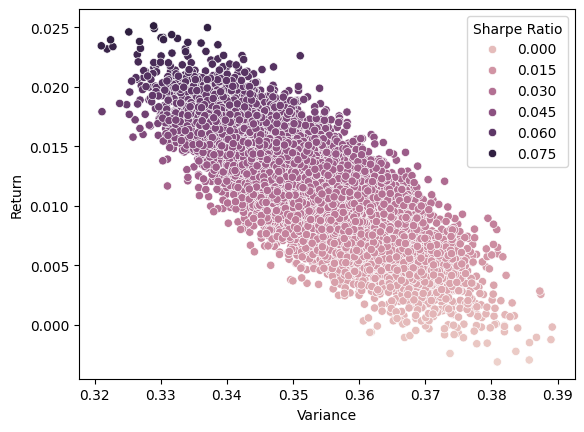

In [7]:
# Annualized the log_returns
log_returns = log_returns_matrix.mean().values * 4

results = pd.DataFrame(columns = ['Return', 'Variance', 'Sharpe Ratio' ])
for idx in range(15000):
    weights = np.array(np.random.random(len(log_returns_matrix.columns)))
    weights = weights / np.sum(weights) ## weights total < 1

    results.loc[idx, 'Return'] = np.sum(log_returns * weights)
    results.loc[idx, 'Variance'] = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix_annualized, weights)))
    results.loc[idx, 'Sharpe Ratio'] = results.loc[idx, 'Return']/results.loc[idx, 'Variance']

sns.scatterplot(results, x='Variance', y='Return', hue = 'Sharpe Ratio')
plt.show()

In [8]:
sr_mean = results['Sharpe Ratio'].mean()
sr_std = results['Sharpe Ratio'].std()
(sr_mean, sr_std)

(0.03199296783247168, 0.011443828972689345)

We can see a clear negative correlation between variance and return : the less variance, the more returns. Which can be counter intuitive.

Well-diversified portfolios can exhibit lower overall variance while achieving stable returns.

We can also see that the Sharpe Ratio have a mean of 0.03, which is very low.
Let see how we can optimize and increase it.

# Portfolio Optimization: Maximize the Sharpe Ratio

To optimize the Sharpe ratio, you typically want to maximize the following objective function:

$$
S = \frac{R_p - R_f}{\sigma_p}
$$
- **Where**:
  - $S$ = Sharpe ratio
  - $R_p$ = Portfolio return
    - $R_p = \sum_{i=1}^{n} w_i \cdot R_i$, Sum of return Weighted
  - $R_f$ = Risk-free rate (to be defined)
  - $sigma_p$ = Portfolio standard deviation (risk)
    - $sigma_p = \sqrt{w^T \Sigma w} $
        - $w$ = Weight of the portfolio
        - $\Sigma$ = Covariance Matrice

<br>

The optimization problem can be framed as follows:

**Maximize:**
$$
S = \frac{\sum_{i=1}^{n} w_i \cdot R_i - R_f}{\sqrt{w^T \Sigma w}}
$$

**Subject to**:
- $\sum_{i=1}^{n} w_i = 1 $
- $w_i \geq 0 $

<br>


As it's difficult problem to resolve with a simple solver, we can have 3 ways to optimize the sharpe ratio :

1.   Following Tütüncü (section 5.2), "Advanced Lecture on Mathematical Science and Information Science I" this can be reformulated under a change of variables to a simpler quadratic optimisation problemm.

    **Minimize: $ y^TQy$**
    
    **Subject to**:
    - $\hat{μ}Ty=1$
    - $\hat{A}y \geq 0$
    - $ 0 \leq y$



2.   Use Markowitz portfolio optimization and plot the efficient frontier, pick the point which is graphically the best Sharpe Ratio.

3. Use a nonlinear programming (NLP) solve (scipy).

## Optimization objectives functions

In [9]:
def calculate_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def calculate_portfolio_returns(weights, returns):
    return np.dot(weights, returns)

def variance_objective(weights, cov_matrix):
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return portfolio_variance

### Using Negative Markowitz Objective, as we will use scipy.optimize.minimize
def neg_markowitz_objective(weights, returns, cov_matrix, gamma = 0.02):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return gamma * portfolio_variance - portfolio_returns

### Using Negative Sharpe Ratio, as we will use scipy.optimize.minimize
def neg_sharpe_ratio_objective(weights, returns, cov_matrix, risk_free_rate = 0):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return -((portfolio_returns - risk_free_rate)/np.sqrt(portfolio_returns))

## **1. Minimize:** $ y^TQy$


TBD

## **2. Maximize Markowitz portfolio optimization**

In [10]:
# Mean Returns
log_returns = log_returns_matrix.mean().values * 4

# Init guess for the weights
init_guess = np.array([1/len(log_returns) for _ in range(len(log_returns))])

result = sp.optimize.minimize(fun=neg_markowitz_objective,
                            x0=init_guess,
                            args=(log_returns, covariance_matrix_annualized),
                            method='SLSQP',
                            bounds=tuple((0,1) for _ in range(len(log_returns))),
                            constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}))

print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.7465579067828821
       x: [ 2.018e-15  0.000e+00 ...  1.105e-15  1.242e-16]
     nit: 5
     jac: [-2.409e-02 -2.203e-01 ... -9.676e-02 -5.936e-02]
    nfev: 2510
    njev: 5


In [11]:
markowitz = -1 * result['fun']
weights =  result['x']

print(f"Markowitz : {markowitz:.3f}")

Markowitz : 0.747


After Runing an optimization solver, we can normaly reach a Sharpe Ratio up to 0.74, which is much higher than the random weights attributions.

### Trace the Efficient Frontier

In [ ]:
# Mean Returns
log_returns = log_returns_matrix.mean().values * 4

# Init guess for the weights
init_guess = np.array([1/len(log_returns) for _ in range(len(log_returns))])

returns = np.linspace(0, 0.25, 25)
variances = []

for one_return in returns:
    result = sp.optimize.minimize(fun=neg_markowitz_objective,
                                  x0=init_guess,
                                  args=(log_returns, covariance_matrix_annualized),
                                  method='SLSQP',
                                  bounds=tuple((0,1) for _ in range(len(log_returns))),
                                  constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                                               {'type':'eq','fun': lambda weights: np.dot(weights, log_returns) - one_return}))

    variances.append(result['fun'])

In [ ]:
frontier = pd.DataFrame({'variances': variances, 'returns': returns})
sns.lineplot(frontier, x='returns', y='variances')
plt.show()

## **3. Direct Optimization of the Sharpe Ratio.**



In [ ]:
# Mean Returns
log_returns = log_returns_matrix.mean().values * 4

# Init guess for the weights
init_guess = np.array([1/len(log_returns) for _ in range(len(log_returns))])

result = sp.optimize.minimize(fun=neg_sharpe_ratio_objective,
                            x0=init_guess,
                            args=(log_returns, covariance_matrix_annualized),
                            method='SLSQP',
                            bounds=tuple((0,1) for _ in range(len(log_returns))),
                            constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}))

print(result)

In [ ]:
sharpe_ratio = -1 * result['fun']
weights =  result['x']

print(f"Sharpe Ratio: {sharpe_ratio:.3f}")